## Import Packages

In [1]:
from data import shortestpath, dataset
from model import shortestPathModel
from loss import SPOPlusLoss

In [2]:
import time
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import torch
from torch import nn
from torch.utils.data import DataLoader

## Build Model 

In [3]:
# model for shortest path
grid = (5,5)
sp_model = shortestPathModel(grid)

Academic license - for non-commercial use only - expires 2021-04-13
Using license file C:\Users\Apocrypse\gurobi.lic


## Training

In [4]:
# build linear model
class LinearRegression(nn.Module):
    
    def __init__(self):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(p, (grid[0] - 1) * grid[1] + (grid[1] - 1) * grid[0])
    
    def forward(self, x):
        out = self.linear(x)
        return out

In [5]:
def train(dataloader, opt_model, num_epochs, learning_rate, l1_lambda):
    """
    train model with SPO+ Loss
    args:
      dataloader: dataloader from optDataSet
      model: optModel
      num_epochs: number of epochs
      l2_lambda: l2 regularization parameter
    """
    print('Training...')
    # init model
    lr = LinearRegression()
    # cuda
    if torch.cuda.is_available():
        lr = lr.cuda()
    # training mode
    lr.train()
    # set optimizer
    optimizer = torch.optim.Adam(lr.parameters(), lr=learning_rate)
    # set SPO+ Loss as criterion
    criterion = SPOPlusLoss()
    # train
    time.sleep(1)
    for epoch in tqdm(range(num_epochs)):
        # load data
        for i, data in enumerate(dataloader):
            x, c, w, z = data
            # cuda
            if torch.cuda.is_available():
                x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
            # forward pass
            cp = lr(x)
            loss = criterion.apply(opt_model, cp, c, w, z).mean()
            # l1 reg
            l1_reg = torch.abs(cp - c).sum(dim=1).mean()
            loss += l1_lambda * l1_reg
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    return lr

## Evaluation 

In [6]:
def evalm(lr, dataloader):
    """
    evaluate model performence
    args:
      lr: linear regression model
      dataloader: dataloader from optDataSet
    """
    # evaluate
    lr.eval()
    # set SPO+ Loss as criterion
    criterion = SPOPlusLoss()
    loss = 0
    optsum = 0
    # load data
    for i, data in enumerate(dataloader):
        x, c, w, z = data
        # cuda
        if torch.cuda.is_available():
            x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
        # predict
        cp = lr(x)
        # accumulate loss
        loss += criterion.apply(sp_model, cp, c, w, z).sum().item()
        optsum += z.sum().item()
    # normalized
    print('Normalized SPO+ Loss: {:.2f}%'.format(loss / optsum * 100))
    return loss / optsum

## Experiments

### Training Set Size = 100, Noise Half−width = 0

In [7]:
# set up
n = 100 # number of data
p = 5 # size of feature
e = 0 # noise half−width
degs = [1, 2, 4, 6] # list of param deg

In [8]:
# init DataFrame
df1 = pd.DataFrame(columns = [1, 2, 4, 6])

In [9]:
for i in range(8):
    row = {}
    for deg in degs:
        # generate data
        x, c = shortestpath.genData(n, p, grid, deg=deg, noise_width=e, seed=i)
        # data split
        x_train, x_test, c_train, c_test = train_test_split(x, c, test_size=0.2, random_state=246)
        # build data set
        sp_dataset_train = dataset.optDataset(sp_model, x_train, c_train)
        sp_dataset_test = dataset.optDataset(sp_model, x_test, c_test)
        # get data loader
        batch_size = 32
        sp_loader_train = DataLoader(sp_dataset_train, batch_size=batch_size, shuffle=True)
        sp_loader_test = DataLoader(sp_dataset_test, batch_size=batch_size, shuffle=False)
        # train
        learning_rate = 1e-3 * (3 ** deg + 1)
        lr = train(sp_loader_train, sp_model, num_epochs=500, learning_rate=learning_rate, l1_lambda=1e-3)
        # eval
        loss = evalm(lr, sp_loader_test)
        row[deg] = loss
        print()
    df1 = df1.append(row, ignore_index = True)

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 298.99it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 320.80it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 500/500 [02:05<00:00,  3.98it/s]


Normalized SPO+ Loss: 4.85%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 320.85it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 262.05it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 500/500 [02:06<00:00,  3.94it/s]


Normalized SPO+ Loss: 11.65%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 292.72it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 344.92it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 500/500 [02:02<00:00,  4.08it/s]


Normalized SPO+ Loss: 29.48%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 415.12it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 391.99it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 500/500 [02:00<00:00,  4.14it/s]


Normalized SPO+ Loss: 395.43%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 294.36it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 357.00it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 500/500 [02:01<00:00,  4.12it/s]


Normalized SPO+ Loss: 2.98%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 411.28it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 364.46it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 500/500 [02:01<00:00,  4.12it/s]


Normalized SPO+ Loss: 16.31%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 403.56it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 426.50it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 500/500 [02:03<00:00,  4.05it/s]


Normalized SPO+ Loss: 96.81%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 343.74it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 385.58it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 500/500 [02:03<00:00,  4.06it/s]


Normalized SPO+ Loss: 403.98%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 322.11it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 271.02it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 500/500 [02:10<00:00,  3.83it/s]


Normalized SPO+ Loss: 4.15%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 323.45it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 215.56it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 500/500 [02:00<00:00,  4.16it/s]


Normalized SPO+ Loss: 9.55%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 379.11it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 334.24it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 500/500 [02:01<00:00,  4.12it/s]


Normalized SPO+ Loss: 86.47%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 391.29it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 455.77it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 500/500 [01:58<00:00,  4.21it/s]


Normalized SPO+ Loss: 287.69%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 273.77it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 393.22it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 500/500 [01:59<00:00,  4.18it/s]


Normalized SPO+ Loss: 20.25%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 406.84it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 345.36it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 500/500 [01:59<00:00,  4.17it/s]


Normalized SPO+ Loss: 50.58%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 354.97it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 294.87it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 500/500 [02:00<00:00,  4.14it/s]


Normalized SPO+ Loss: 194.89%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 384.48it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 445.29it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 500/500 [02:04<00:00,  4.01it/s]


Normalized SPO+ Loss: 523.04%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 300.51it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 268.72it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 500/500 [02:08<00:00,  3.88it/s]


Normalized SPO+ Loss: 24.82%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 323.85it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 385.65it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 500/500 [02:04<00:00,  4.02it/s]


Normalized SPO+ Loss: 33.71%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 255.36it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 318.31it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 500/500 [02:01<00:00,  4.10it/s]


Normalized SPO+ Loss: 36.68%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 351.82it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 401.14it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 500/500 [02:03<00:00,  4.05it/s]


Normalized SPO+ Loss: 188.98%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 362.96it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 253.93it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 500/500 [02:06<00:00,  3.96it/s]


Normalized SPO+ Loss: 17.06%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 271.38it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 260.44it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 500/500 [02:03<00:00,  4.05it/s]


Normalized SPO+ Loss: 8.45%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 320.85it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 231.80it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 500/500 [02:07<00:00,  3.94it/s]


Normalized SPO+ Loss: 72.81%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 296.53it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 244.58it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 500/500 [02:12<00:00,  3.78it/s]


Normalized SPO+ Loss: 770.88%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 276.60it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 385.67it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 500/500 [02:12<00:00,  3.78it/s]


Normalized SPO+ Loss: 1.44%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 268.61it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 401.02it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 500/500 [02:04<00:00,  4.02it/s]


Normalized SPO+ Loss: 9.66%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 320.74it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 385.65it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 500/500 [02:02<00:00,  4.07it/s]


Normalized SPO+ Loss: 42.78%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 271.22it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 247.58it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 500/500 [02:04<00:00,  4.01it/s]


Normalized SPO+ Loss: 173.12%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 367.96it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 274.58it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 500/500 [02:05<00:00,  3.97it/s]


Normalized SPO+ Loss: 42.26%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 378.71it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 364.60it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 500/500 [02:04<00:00,  4.01it/s]


Normalized SPO+ Loss: 36.38%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 408.41it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 466.67it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 500/500 [02:10<00:00,  3.82it/s]


Normalized SPO+ Loss: 384.60%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 270.99it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 306.11it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 500/500 [02:12<00:00,  3.77it/s]

Normalized SPO+ Loss: 517.37%



Text(0, 0.5, 'Normalized SPO+ Loss')

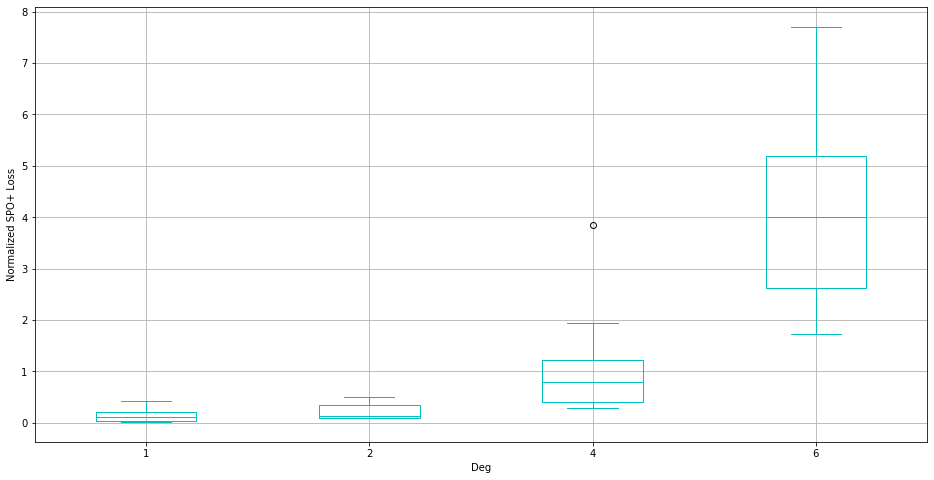

In [10]:
# draw boxplot
bplot = df1.boxplot(figsize=(16,8), color='c')
bplot.set_xlabel('Deg')
bplot.set_ylabel('Normalized SPO+ Loss')

### Training Set Size = 100, Noise Half−width = 0.5

In [11]:
# set
n = 100 # number of data
p = 5 # size of feature
e = 0.5 # noise half−width
degs = [1, 2, 4, 6] # list of param deg

In [12]:
# init DataFrame
df2 = pd.DataFrame(columns = [1, 2, 4, 6])

In [13]:
for i in range(8):
    row = {}
    for deg in degs:
        # generate data
        x, c = shortestpath.genData(n, p, grid, deg=deg, noise_width=e, seed=i)
        # data split
        x_train, x_test, c_train, c_test = train_test_split(x, c, test_size=0.2, random_state=246)
        # build data set
        sp_dataset_train = dataset.optDataset(sp_model, x_train, c_train)
        sp_dataset_test = dataset.optDataset(sp_model, x_test, c_test)
        # get data loader
        batch_size = 32
        sp_loader_train = DataLoader(sp_dataset_train, batch_size=batch_size, shuffle=True)
        sp_loader_test = DataLoader(sp_dataset_test, batch_size=batch_size, shuffle=False)
        # train
        learning_rate = 1e-3 * (3 ** deg + 1)
        lr = train(sp_loader_train, sp_model, num_epochs=500, learning_rate=learning_rate, l1_lambda=1e-3)
        # eval
        loss = evalm(lr, sp_loader_test)
        row[deg] = loss
        print()
    df2 = df2.append(row, ignore_index = True)

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 364.56it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 244.55it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 500/500 [02:05<00:00,  4.00it/s]


Normalized SPO+ Loss: 6.78%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 334.84it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 409.25it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 500/500 [02:03<00:00,  4.03it/s]


Normalized SPO+ Loss: 14.96%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 350.28it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 371.35it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 500/500 [02:03<00:00,  4.05it/s]


Normalized SPO+ Loss: 47.81%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 362.88it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 401.07it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 500/500 [02:04<00:00,  4.03it/s]


Normalized SPO+ Loss: 349.98%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 335.64it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 339.88it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 500/500 [02:06<00:00,  3.95it/s]


Normalized SPO+ Loss: 22.55%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 225.03it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 217.54it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 500/500 [02:10<00:00,  3.83it/s]


Normalized SPO+ Loss: 21.07%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 405.12it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 364.47it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 500/500 [02:06<00:00,  3.96it/s]


Normalized SPO+ Loss: 125.36%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 389.36it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 366.52it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 500/500 [02:07<00:00,  3.94it/s]


Normalized SPO+ Loss: 363.23%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 369.64it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 294.95it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 500/500 [02:05<00:00,  3.99it/s]


Normalized SPO+ Loss: 4.95%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 340.72it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 426.14it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 500/500 [02:04<00:00,  4.00it/s]


Normalized SPO+ Loss: 13.80%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 327.38it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 339.91it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 500/500 [02:04<00:00,  4.01it/s]


Normalized SPO+ Loss: 78.37%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 376.60it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 202.01it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 500/500 [02:06<00:00,  3.94it/s]


Normalized SPO+ Loss: 280.97%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 342.79it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 172.11it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 500/500 [02:06<00:00,  3.94it/s]


Normalized SPO+ Loss: 19.83%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 371.36it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 371.54it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 500/500 [02:05<00:00,  4.00it/s]


Normalized SPO+ Loss: 37.81%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 335.62it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 247.57it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 500/500 [02:06<00:00,  3.95it/s]


Normalized SPO+ Loss: 167.44%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 364.84it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 422.11it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 500/500 [02:10<00:00,  3.82it/s]


Normalized SPO+ Loss: 537.87%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 358.10it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 358.10it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 500/500 [02:04<00:00,  4.02it/s]


Normalized SPO+ Loss: 10.42%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 338.51it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 244.55it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 500/500 [02:05<00:00,  3.99it/s]


Normalized SPO+ Loss: 7.37%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 355.03it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 294.89it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 500/500 [02:10<00:00,  3.82it/s]


Normalized SPO+ Loss: 41.35%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 335.62it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 263.86it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 500/500 [02:09<00:00,  3.86it/s]


Normalized SPO+ Loss: 224.37%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 391.27it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 435.96it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 500/500 [02:07<00:00,  3.93it/s]


Normalized SPO+ Loss: 12.62%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 404.54it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 286.50it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 500/500 [02:04<00:00,  4.00it/s]


Normalized SPO+ Loss: 26.16%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 391.28it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 374.77it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 500/500 [02:05<00:00,  3.99it/s]


Normalized SPO+ Loss: 63.87%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 345.70it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 435.94it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 500/500 [02:03<00:00,  4.06it/s]


Normalized SPO+ Loss: 230.07%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 274.73it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 227.89it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 500/500 [02:21<00:00,  3.53it/s]


Normalized SPO+ Loss: 0.53%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 325.66it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 385.85it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 500/500 [02:00<00:00,  4.16it/s]


Normalized SPO+ Loss: 11.29%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 398.07it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 401.06it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 500/500 [02:04<00:00,  4.00it/s]


Normalized SPO+ Loss: 47.66%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 338.45it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 271.00it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 500/500 [02:06<00:00,  3.95it/s]


Normalized SPO+ Loss: 110.07%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 320.85it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 371.35it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 500/500 [02:02<00:00,  4.07it/s]


Normalized SPO+ Loss: 33.81%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 325.10it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 477.89it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 500/500 [02:00<00:00,  4.16it/s]


Normalized SPO+ Loss: 170.19%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 315.09it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 244.85it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 500/500 [02:06<00:00,  3.96it/s]


Normalized SPO+ Loss: 117.82%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 358.10it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 409.01it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 500/500 [02:08<00:00,  3.90it/s]

Normalized SPO+ Loss: 673.88%



Text(0, 0.5, 'Normalized SPO+ Loss')

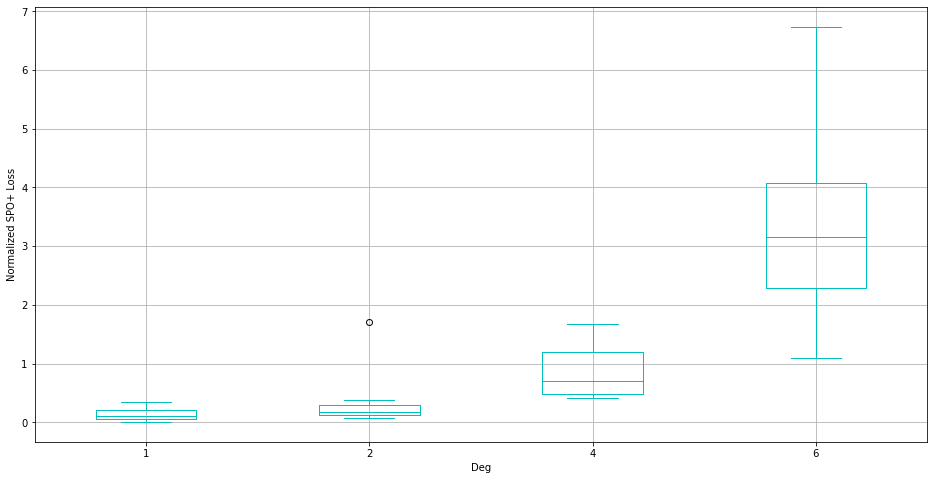

In [14]:
# draw boxplot
bplot = df2.boxplot(figsize=(16,8), color='c')
bplot.set_xlabel('Deg')
bplot.set_ylabel('Normalized SPO+ Loss')

## Training Set Size = 1000, Noise Half−width = 0 

In [15]:
# set
n = 1000 # number of data
p = 5 # size of feature
e = 0 # noise half−width
degs = [1, 2, 4, 6] # list of param deg

In [16]:
# init DataFrame
df3 = pd.DataFrame(columns = [1, 2, 4, 6])

In [17]:
for i in range(8):
    row = {}
    for deg in degs:
        # generate data
        x, c = shortestpath.genData(n, p, grid, deg=deg, noise_width=e, seed=i)
        # data split
        x_train, x_test, c_train, c_test = train_test_split(x, c, test_size=0.2, random_state=246)
        # build data set
        sp_dataset_train = dataset.optDataset(sp_model, x_train, c_train)
        sp_dataset_test = dataset.optDataset(sp_model, x_test, c_test)
        # get data loader
        batch_size = 32
        sp_loader_train = DataLoader(sp_dataset_train, batch_size=batch_size, shuffle=True)
        sp_loader_test = DataLoader(sp_dataset_test, batch_size=batch_size, shuffle=False)
        # train
        learning_rate = 1e-3 * (3 ** deg + 1)
        lr = train(sp_loader_train, sp_model, num_epochs=100, learning_rate=learning_rate, l1_lambda=1e-3)
        # eval
        loss = evalm(lr, sp_loader_test)
        row[deg] = loss
        print()
    df3 = df3.append(row, ignore_index = True)

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 800/800 [00:02<00:00, 339.26it/s]


Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 315.24it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [04:06<00:00,  2.47s/it]


Normalized SPO+ Loss: 0.38%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 800/800 [00:02<00:00, 341.58it/s]


Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 340.99it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [04:03<00:00,  2.44s/it]


Normalized SPO+ Loss: 6.01%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 800/800 [00:02<00:00, 334.52it/s]


Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 359.48it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [04:02<00:00,  2.43s/it]


Normalized SPO+ Loss: 51.41%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 800/800 [00:02<00:00, 333.94it/s]


Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 325.30it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [04:10<00:00,  2.50s/it]


Normalized SPO+ Loss: 274.90%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 800/800 [00:02<00:00, 300.86it/s]


Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 371.49it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [04:05<00:00,  2.45s/it]


Normalized SPO+ Loss: 0.63%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 800/800 [00:02<00:00, 349.07it/s]


Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 399.86it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [04:06<00:00,  2.46s/it]


Normalized SPO+ Loss: 4.70%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 800/800 [00:02<00:00, 343.57it/s]


Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 388.63it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [04:10<00:00,  2.51s/it]


Normalized SPO+ Loss: 34.19%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 800/800 [00:02<00:00, 333.98it/s]


Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 405.88it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [04:10<00:00,  2.51s/it]


Normalized SPO+ Loss: 158.12%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 800/800 [00:02<00:00, 348.00it/s]


Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 341.04it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [04:00<00:00,  2.41s/it]


Normalized SPO+ Loss: 0.41%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 800/800 [00:02<00:00, 371.88it/s]


Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 306.67it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [03:56<00:00,  2.37s/it]


Normalized SPO+ Loss: 5.97%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 800/800 [00:02<00:00, 344.71it/s]


Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 311.35it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [03:58<00:00,  2.38s/it]


Normalized SPO+ Loss: 45.79%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 800/800 [00:02<00:00, 375.71it/s]


Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 416.89it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [04:05<00:00,  2.46s/it]


Normalized SPO+ Loss: 179.46%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 800/800 [00:02<00:00, 393.59it/s]


Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 338.74it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [03:51<00:00,  2.31s/it]


Normalized SPO+ Loss: 0.63%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 800/800 [00:02<00:00, 345.30it/s]


Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 386.39it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [03:49<00:00,  2.30s/it]


Normalized SPO+ Loss: 5.79%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 800/800 [00:01<00:00, 401.27it/s]


Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 404.30it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [03:48<00:00,  2.29s/it]


Normalized SPO+ Loss: 44.59%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 800/800 [00:02<00:00, 375.71it/s]


Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 321.37it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [03:58<00:00,  2.38s/it]


Normalized SPO+ Loss: 205.79%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 800/800 [00:02<00:00, 378.73it/s]


Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 356.19it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [03:52<00:00,  2.33s/it]


Normalized SPO+ Loss: 0.53%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 800/800 [00:02<00:00, 346.71it/s]


Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 367.30it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [03:50<00:00,  2.30s/it]


Normalized SPO+ Loss: 7.42%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 800/800 [00:02<00:00, 355.09it/s]


Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 339.33it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [03:49<00:00,  2.30s/it]


Normalized SPO+ Loss: 40.44%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 800/800 [00:02<00:00, 372.22it/s]


Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 387.88it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [03:54<00:00,  2.34s/it]


Normalized SPO+ Loss: 130.27%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 800/800 [00:02<00:00, 327.94it/s]


Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 379.08it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [03:57<00:00,  2.38s/it]


Normalized SPO+ Loss: 0.49%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 800/800 [00:02<00:00, 330.23it/s]


Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 410.09it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [03:53<00:00,  2.34s/it]


Normalized SPO+ Loss: 5.73%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 800/800 [00:02<00:00, 392.82it/s]


Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 376.94it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [03:52<00:00,  2.32s/it]


Normalized SPO+ Loss: 42.91%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 800/800 [00:02<00:00, 367.96it/s]


Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 258.75it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [03:49<00:00,  2.29s/it]


Normalized SPO+ Loss: 228.78%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 800/800 [00:02<00:00, 384.72it/s]


Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 374.83it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [03:52<00:00,  2.33s/it]


Normalized SPO+ Loss: 0.39%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 800/800 [00:02<00:00, 346.65it/s]


Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 341.03it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [03:57<00:00,  2.38s/it]


Normalized SPO+ Loss: 5.16%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 800/800 [00:02<00:00, 349.82it/s]


Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 370.67it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [03:50<00:00,  2.30s/it]


Normalized SPO+ Loss: 35.69%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 800/800 [00:02<00:00, 339.31it/s]


Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 377.66it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [03:50<00:00,  2.31s/it]


Normalized SPO+ Loss: 155.53%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 800/800 [00:02<00:00, 362.30it/s]


Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 366.61it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [03:50<00:00,  2.30s/it]


Normalized SPO+ Loss: 0.68%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 800/800 [00:02<00:00, 336.89it/s]


Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 371.36it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [03:50<00:00,  2.30s/it]


Normalized SPO+ Loss: 5.17%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 800/800 [00:02<00:00, 349.83it/s]


Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 341.63it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [03:53<00:00,  2.33s/it]


Normalized SPO+ Loss: 44.16%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 800/800 [00:02<00:00, 343.09it/s]


Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 340.47it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [03:52<00:00,  2.32s/it]


Normalized SPO+ Loss: 140.53%



Text(0, 0.5, 'Normalized SPO+ Loss')

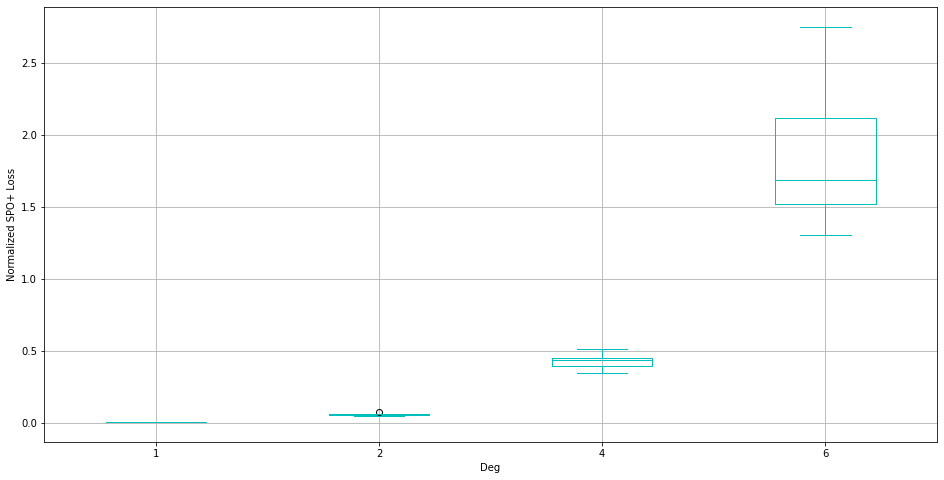

In [18]:
# draw boxplot
bplot = df3.boxplot(figsize=(16,8), color='c')
bplot.set_xlabel('Deg')
bplot.set_ylabel('Normalized SPO+ Loss')

## Training Set Size = 1000, Noise Half−width = 0.5 

In [19]:
# set
n = 1000 # number of data
p = 5 # size of feature
e = 0.5 # noise half−width
degs = [1, 2, 4, 6] # list of param deg

In [20]:
# init DataFrame
df4 = pd.DataFrame(columns = [1, 2, 4, 6])

In [21]:
for i in range(8):
    row = {}
    for deg in degs:
        # generate data
        x, c = shortestpath.genData(n, p, grid, deg=deg, noise_width=e, seed=i)
        # data split
        x_train, x_test, c_train, c_test = train_test_split(x, c, test_size=0.2, random_state=246)
        # build data set
        sp_dataset_train = dataset.optDataset(sp_model, x_train, c_train)
        sp_dataset_test = dataset.optDataset(sp_model, x_test, c_test)
        # get data loader
        batch_size = 32
        sp_loader_train = DataLoader(sp_dataset_train, batch_size=batch_size, shuffle=True)
        sp_loader_test = DataLoader(sp_dataset_test, batch_size=batch_size, shuffle=False)
        # train
        learning_rate = 1e-3 * (3 ** deg + 1)
        lr = train(sp_loader_train, sp_model, num_epochs=100, learning_rate=learning_rate, l1_lambda=1e-3)
        # eval
        loss = evalm(lr, sp_loader_test)
        row[deg] = loss
        print()
    df4 = df4.append(row, ignore_index = True)

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 800/800 [00:02<00:00, 327.00it/s]


Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 381.97it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [03:53<00:00,  2.34s/it]


Normalized SPO+ Loss: 0.40%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 800/800 [00:02<00:00, 358.58it/s]


Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 410.09it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [03:55<00:00,  2.35s/it]


Normalized SPO+ Loss: 5.92%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 800/800 [00:02<00:00, 365.43it/s]


Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 349.36it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [03:58<00:00,  2.39s/it]


Normalized SPO+ Loss: 55.78%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 800/800 [00:02<00:00, 385.64it/s]


Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 353.68it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [03:52<00:00,  2.33s/it]


Normalized SPO+ Loss: 269.78%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 800/800 [00:02<00:00, 357.78it/s]


Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 305.21it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [03:54<00:00,  2.34s/it]


Normalized SPO+ Loss: 0.46%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 800/800 [00:02<00:00, 346.20it/s]


Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 351.82it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [03:54<00:00,  2.35s/it]


Normalized SPO+ Loss: 5.21%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 800/800 [00:02<00:00, 327.54it/s]


Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 328.21it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [04:06<00:00,  2.46s/it]


Normalized SPO+ Loss: 37.22%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 800/800 [00:02<00:00, 363.45it/s]


Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 311.86it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [03:57<00:00,  2.38s/it]


Normalized SPO+ Loss: 172.86%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 800/800 [00:02<00:00, 364.28it/s]


Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 369.31it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [03:59<00:00,  2.40s/it]


Normalized SPO+ Loss: 0.61%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 800/800 [00:02<00:00, 314.07it/s]


Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 308.99it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [04:00<00:00,  2.41s/it]


Normalized SPO+ Loss: 6.45%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 800/800 [00:02<00:00, 352.59it/s]


Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 424.89it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [03:57<00:00,  2.37s/it]


Normalized SPO+ Loss: 44.10%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 800/800 [00:02<00:00, 378.72it/s]


Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 369.31it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [03:51<00:00,  2.31s/it]


Normalized SPO+ Loss: 168.29%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 800/800 [00:02<00:00, 354.20it/s]


Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 346.95it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [03:55<00:00,  2.36s/it]


Normalized SPO+ Loss: 0.48%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 800/800 [00:02<00:00, 335.20it/s]


Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 401.87it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [03:57<00:00,  2.38s/it]


Normalized SPO+ Loss: 4.96%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 800/800 [00:02<00:00, 347.10it/s]


Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 372.74it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [04:02<00:00,  2.42s/it]


Normalized SPO+ Loss: 52.93%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 800/800 [00:02<00:00, 342.21it/s]


Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 365.27it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [04:06<00:00,  2.46s/it]


Normalized SPO+ Loss: 214.64%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 800/800 [00:02<00:00, 342.65it/s]


Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 389.39it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [04:01<00:00,  2.42s/it]


Normalized SPO+ Loss: 0.48%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 800/800 [00:02<00:00, 336.55it/s]


Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 372.05it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [03:53<00:00,  2.33s/it]


Normalized SPO+ Loss: 6.85%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 800/800 [00:02<00:00, 351.97it/s]


Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 341.63it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [03:55<00:00,  2.36s/it]


Normalized SPO+ Loss: 40.08%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 800/800 [00:02<00:00, 349.66it/s]


Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 386.39it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [03:49<00:00,  2.29s/it]


Normalized SPO+ Loss: 134.78%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 800/800 [00:02<00:00, 361.32it/s]


Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 390.91it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [03:47<00:00,  2.27s/it]


Normalized SPO+ Loss: 0.59%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 800/800 [00:02<00:00, 354.45it/s]


Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 410.91it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [03:55<00:00,  2.36s/it]


Normalized SPO+ Loss: 7.48%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 800/800 [00:02<00:00, 364.11it/s]


Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 373.07it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [03:54<00:00,  2.34s/it]


Normalized SPO+ Loss: 55.58%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 800/800 [00:02<00:00, 338.19it/s]


Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 331.47it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [04:02<00:00,  2.43s/it]


Normalized SPO+ Loss: 251.02%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 800/800 [00:02<00:00, 348.15it/s]


Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 373.46it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [04:04<00:00,  2.45s/it]


Normalized SPO+ Loss: 0.76%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 800/800 [00:02<00:00, 361.16it/s]


Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 318.82it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [03:57<00:00,  2.38s/it]


Normalized SPO+ Loss: 5.24%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 800/800 [00:02<00:00, 315.93it/s]


Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 290.21it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [04:06<00:00,  2.47s/it]


Normalized SPO+ Loss: 35.32%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 800/800 [00:02<00:00, 373.61it/s]


Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 378.37it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [04:01<00:00,  2.41s/it]


Normalized SPO+ Loss: 166.43%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 800/800 [00:02<00:00, 354.15it/s]


Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 366.61it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [04:01<00:00,  2.41s/it]


Normalized SPO+ Loss: 0.60%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 800/800 [00:02<00:00, 346.34it/s]


Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 369.31it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [03:58<00:00,  2.38s/it]


Normalized SPO+ Loss: 5.62%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 800/800 [00:02<00:00, 340.90it/s]


Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 280.47it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [04:01<00:00,  2.41s/it]


Normalized SPO+ Loss: 45.69%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 800/800 [00:02<00:00, 348.76it/s]


Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 334.23it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [03:57<00:00,  2.37s/it]


Normalized SPO+ Loss: 175.34%



Text(0, 0.5, 'Normalized SPO+ Loss')

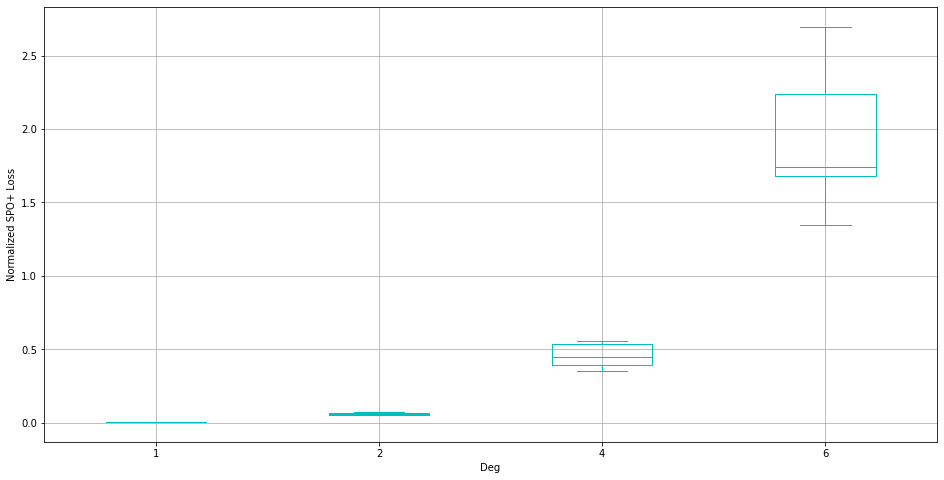

In [22]:
# draw boxplot
bplot = df4.boxplot(figsize=(16,8), color='c')
bplot.set_xlabel('Deg')
bplot.set_ylabel('Normalized SPO+ Loss')